## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

## Loading data

In [2]:
books = pd.read_csv('books_cleaned.csv')

ratings = pd.read_csv('ratings.csv')

##### We will use the ratings to train our model and based on the predicted ratings we will recommned books to the user from the books dataset.

## Splitting the data

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Shape of train data: {train.shape}")
print(f"Shape of test data: {test.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


We will use the test set for validation purpose only.

### Basic overview of the architecture

The Neural Network architecture we’re going to create will have two input embedding layers. The first embedding layer accepts the books, and the second the users. These two embeddings are trained separately and then combined together before being passed to a dense layer.




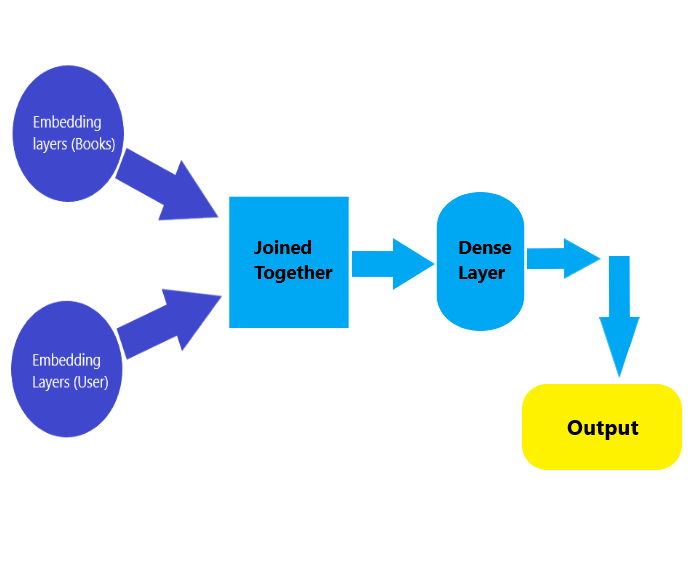

#### We will create seperate embedding layers for the two and then concatenate them, pass them through a dense layer and finally an output layer that will predict a single rating.

Let's grab the no. of unique book_id and user_id from the ratings dataset

In [4]:
#nunique() will return the total number of unique items

book_id = ratings.book_id.nunique() 

user_id = ratings.user_id.nunique()

In [5]:
print('Total books: ' + str(book_id))
print('Total users: ' + str(user_id))

Total books: 10000
Total users: 53424


######  

## Model building

In [6]:
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [7]:
#Embedding layer for books
books_input = Input(shape=[1])#1st Input Layer
embedding_layer_books = Embedding(book_id + 1,10)(books_input)#Embedding layer
embedding_output_books = Flatten()(embedding_layer_books)#Embedding layer output

#Embedding layer for users
users_input = Input(shape=[1])#1st Input Layer
embedding_layer_users = Embedding(user_id + 1,10)(users_input)#Embedding layer
embedding_output_users = Flatten()(embedding_layer_users)#Embedding layer output

**Note:** We are appending the input layers on top of embedding layers. This is an action of functional API. It basically means that the outputs of those input layers is passed on to the embedding layers.

In [8]:
#Concatination and Dense layer

joining_layer = Concatenate()([embedding_output_books, embedding_output_users])
hidden_layer_1 = Dense(128, activation='relu')(joining_layer)
hidden_layer_1 = Dropout(0.5)(hidden_layer_1)

output_layer = hidden_layer_2 = Dense(1)(hidden_layer_1)

model = tf.keras.Model([books_input, users_input], output_layer)

**Note:** Here also we passed the output of the joining layer to the hidden dense layer, output of the hidden layer to the final output layer. 

In [9]:
#Model compilation

optimizer = Adam(lr=0.001, epsilon = 1e-6, amsgrad=True) #epsilon = decay rate
model.compile(optimizer = optimizer, loss = 'mean_squared_error')#Using mean squared error as loss function

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        100010      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        534250      input_2[0][0]                    
_______________________________________________________________________________________

In [10]:
#Training model

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 1)

model.fit(
    [train.book_id, train.user_id], train.rating, 
    batch_size=64, 
    epochs=15, 
    verbose=1,
    callbacks = [early_stopping],
    validation_data=([test.book_id, test.user_id], test.rating))

Epoch 1/15
12272/12272 [==============================] - 94s 8ms/step - loss: 1.0344 - val_loss: 0.7296
Epoch 2/15
12272/12272 [==============================] - 95s 8ms/step - loss: 0.7978 - val_loss: 0.7134
Epoch 3/15
12272/12272 [==============================] - 95s 8ms/step - loss: 0.7434 - val_loss: 0.7076
Epoch 4/15
12272/12272 [==============================] - 95s 8ms/step - loss: 0.7115 - val_loss: 0.7049
Epoch 5/15
12272/12272 [==============================] - 100s 8ms/step - loss: 0.6856 - val_loss: 0.7055


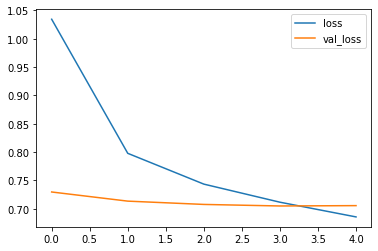

In [11]:
loss = pd.DataFrame(model.history.history)

loss[['loss', 'val_loss']].plot()

Final training loss= 0.68

Final validation loss = 0.70

In [13]:
#Saving the model
model.save('model.h5')